In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as funct
import gymnasium as gym
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
from time import sleep
from IPython import display
import copy
from itertools import count

In [12]:
#Just to get rid of annoying warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=np.VisibleDeprecationWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [13]:
env = gym.make("CartPole-v1", render_mode="human" )

In [14]:
class NN(nn.Module):
    """A Feed Forward Neural Network used for Deep-Q-Learning to solve the cartpole problem."""
    def __init__(self, obs_dim = env.observation_space.shape, n_actions = env.action_space.n):
        super(NN, self).__init__()      
        # The input (an observation/a state) has shape (4,) [cart pos, cart vel, pole angle, pole angular vel]
        self.fc1 = nn.Linear(*obs_dim, 128) # * to convert tuple (4,) to 4
        self.fc21 = nn.Linear(128, 128)
        self.fc22 = nn.Linear(128, 128)
        self.fc23 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions) # n_actions == 2

        self.optimizer = optim.Adam(self.parameters(), lr=1e-4)
        self.loss = nn.MSELoss() #Possibly replace with nn.HuberLoss or SmoothL1Loss -- MSELoss best !?
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, x):
        x = funct.relu(self.fc1(x))
        x = funct.relu(self.fc21(x))
        x = funct.relu(self.fc22(x))
        x = funct.relu(self.fc23(x))
        return self.fc3(x)

In [15]:
class ReplayBuffer(object):
    """A buffer in which the last <mem_size> trajectories are saved for later reuse.
    For training the DQN [train()], trajectories are sampled from it randomly.
    """
    def __init__(self, mem_size = 1000):
        # The maximum number of trajectories that are being kept track of at once.
        self.mem_size = mem_size
        # Tracking the number of additions made to the buffer.
        self.save_cntr = 0
        #the memory which stores the trajectories
        self.memory = []

    #add a new trajectorie to the memory
    def save(self, state, action, reward, state_, is_terminal):

        #append if mem_size isn't reached
        if self.save_cntr < self.mem_size:
            self.memory.append([state,action,reward,state_,is_terminal])
        #override otherwise
        else:
            index = self.save_cntr % self.mem_size
            self.memory[index] = [state,action,reward,state_,is_terminal]

        self.save_cntr += 1

    #get a sample of size batch_size
    def sample(self, batch_size):
        
        max_mem = min(self.save_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        mem_batch = []
        
        for i in batch:
            mem_batch.append(self.memory[i])

        states = [s[0].numpy() for s in mem_batch]
        actions = [a[1] for a in mem_batch]
        rewards = [r[2] for r in mem_batch]
        states_ = [s[3] for s in mem_batch]
        terminals = [t[4] for t in mem_batch]

        return states,  actions, rewards, states_, terminals


In [16]:
class Agent():
    # represents the agent of the RL
    def __init__(self, net = NN(), buf = ReplayBuffer(),
                 obs_dim = env.observation_space.shape, n_actions = env.action_space.n, 
                 discount=0.99, eps = 0.99, eps_dec = 1e-4, eps_end = 0.05, batch_size = 10):
        
        self.obs_dim = obs_dim
        self.n_actions = n_actions
        self.action_space = [i for i in range(n_actions)]
        self.discount = discount
        self.eps = eps
        self.eps_dec = eps_dec
        self.eps_min = eps_end
        self.batch_size = batch_size
        self.net = net
        self.buf = buf

    def pick_action(self, state):
        if np.random.random() > self.eps:
            # Exploitation, meaning we use the model to choose what action (left or right) to take next
            actions = self.net.forward(state) 
            action =  torch.argmax(actions).item()
        else:
            # Exploration, meaning we sample uniformly from the action space (left, right)
            action = np.random.choice(self.action_space)

        # decrease epsilon after every step up to eps_min
        self.eps -= self.eps_dec if self.eps > self.eps_min else 0
        return action
    
    #train the nn of the agent with the q algorithm   
    def train(self):
        
        if self.buf.save_cntr < self.batch_size: return 

        self.net.optimizer.zero_grad()

        batch_index = np.arange(self.batch_size, dtype=np.int32)
        s, a, r, s_, t = self.buf.sample(self.batch_size)
        
        state_batch = torch.tensor(s).to(self.net.device)
        action_batch = a
        next_state_batch = torch.tensor(s_).to(self.net.device)
        reward_batch = torch.tensor(r).to(self.net.device)
        is_terminal_batch = torch.tensor(t).to(self.net.device)

        #Q-Learning
        q_now = self.net.forward(state_batch)[batch_index, action_batch]
        q_next = self.net.forward(next_state_batch)
        
        q_next[is_terminal_batch] = 0.0

        q_target = reward_batch + self.discount*torch.max(q_next, dim=1)[0]

        loss = self.net.loss(q_target, q_now).to(self.net.device)
        loss.backward()
        self.net.optimizer.step()

In [17]:
#plot the result (score after episodes)
#blue: score per episode
#red: mean score for the last n episodes
def plot(scores, means):
    plt.plot(scores, color="b")
    plt.plot(means, color="r")
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.show()

In [18]:
#run the algorithm and train the agent
#min_episodes: the agent will be trained for atleast min_episodes episodes
#e_train: True -> break after min_episodes; False -> break after min_episodes and if the agent didn't achived a better score
def execute(min_episodes = 400, e_train = False, update_freq = 100, agent = Agent(), max_repeats = 3):
    
    #stores the scores and mean scores
    scores, means = [], []

    counter = 1
    repeat = 0
    highest_score = 0

    #stores the best agent
    best_agent = None

    for counter in count(1):
        
        score = 0
        terminated = False
        truncated = False

        # This obs is the observation of the initial state
        obs, _ = env.reset()
        obs = torch.tensor(obs, dtype=torch.float, device=agent.net.device)

        while not terminated and not truncated:
            action = agent.pick_action(obs)
            obs_, reward, terminated, truncated, _ = env.step(action)
            # Save this transition into the the agent's ReplayBuffer
            agent.buf.save(obs, action, reward, obs_, terminated or truncated)
            score += reward
            # Train the model using batch
            agent.train()
            # Moving to the next state: s_t := s_t+1
            obs = torch.tensor(obs_, dtype=torch.float, device=agent.net.device)
            
        # the episode ended; the accumulated rewards are saved
        scores.append(score)
        means.append(np.mean(scores[-update_freq:]))

        #print the score after ever n episodes; 
        if counter % update_freq == 0:
            # The mean of the last <update_freq> scores
            repeat += 1
            avg_score = np.mean(scores[-update_freq:])
            max_score = max(scores[-update_freq:])
            print(f"Episode: {counter} -- Average score: {avg_score} -- Highest of last {update_freq}: {max_score}")

            #if a new best avg_score are achived: store the agent as new best_agent
            if avg_score > highest_score:
                best_agent = copy.deepcopy(agent)
                repeat = 0
                highest_score = avg_score
        
        #if min_episoded are reached (and the agent didn't get better): break
        if counter >= min_episodes and (e_train or repeat >= max_repeats):
            break
    
    plot(scores, means)

    return best_agent

In [19]:
agent = Agent(buf=ReplayBuffer(mem_size=1000))

# Hinweis

Das Training dauert sehr lange!!! Um eine "schnelles" Training zu bekommen, setze min_episodes auf 400 und e_Train auf True. Das Training sollte nicht länger als 12 Minuten dauern, das Ergebniss ist aber nicht optimal!!! 

Vollständiges Training dauert: ca 55min

Episode: 50 -- Average score: 21.12 -- Highest of last 50: 56.0
Episode: 100 -- Average score: 24.64 -- Highest of last 50: 69.0
Episode: 150 -- Average score: 26.94 -- Highest of last 50: 79.0
Episode: 200 -- Average score: 36.9 -- Highest of last 50: 89.0
Episode: 250 -- Average score: 67.54 -- Highest of last 50: 130.0
Episode: 300 -- Average score: 111.86 -- Highest of last 50: 199.0
Episode: 350 -- Average score: 167.02 -- Highest of last 50: 379.0
Episode: 400 -- Average score: 188.28 -- Highest of last 50: 498.0
Episode: 450 -- Average score: 190.74 -- Highest of last 50: 455.0
Episode: 500 -- Average score: 216.42 -- Highest of last 50: 500.0
Episode: 550 -- Average score: 378.1 -- Highest of last 50: 500.0
Episode: 600 -- Average score: 358.44 -- Highest of last 50: 500.0
Episode: 650 -- Average score: 385.64 -- Highest of last 50: 500.0
Episode: 700 -- Average score: 317.04 -- Highest of last 50: 500.0
Episode: 750 -- Average score: 296.82 -- Highest of last 50: 500.0
Episode

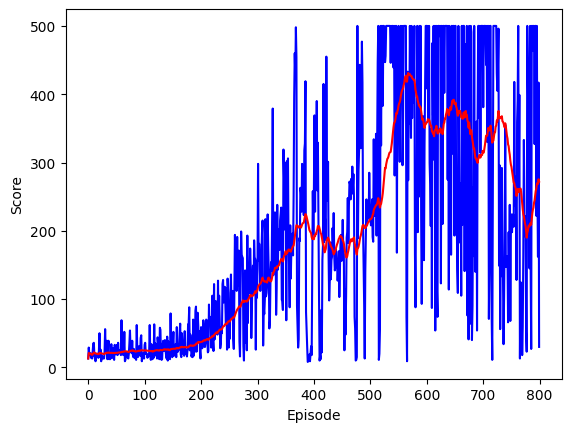

In [20]:
t_agent = execute(min_episodes=500, e_train= False, update_freq=50, agent= agent)

In [27]:
#play the game once
def play(agent):
   obs, _ = env.reset()
   obs = torch.tensor(obs, dtype=torch.float, device=agent.net.device)
   score = 0
   terminated = False
   truncated = False
   while not terminated and not truncated: # delete "and not truncated" and the agent will play "forever" :)
      action = agent.pick_action(obs)
      obs_, reward, terminated, truncated, _ = env.step(action)
      obs = torch.tensor(obs_, dtype=torch.float, device=agent.net.device)
      display.clear_output(wait=True)
      score += 1
      print("Score: " + str(score))
      #sleep(0.1)
   return score
   

In [26]:
play(t_agent)
#env.close()  

Score: 500


500